<img src='images/TransmissionData.png' width='280px' style="float:left;margin-right:10pt;margin-top:20pt"></img>
# The NWHypergraph library for optimizing Static Hypergraph methods

The Transmission Problem: In this tutorial we highlight the use of the NWHy library with HNX. We use a synthetically generated dataset to simulate the many to many relationship between a small group of **senders** of magazine or social media subscriptions and a large group of **receivers**. 


In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from collections import OrderedDict, defaultdict
import pandas as pd
import numpy as np

import hypernetx as hnx
try:
    import nwhy
except ImportError:
    print('NWHy is not available.')

NWHy is not available.


**To use this tutorial with NWHy you will need to install it in your environment. Please see the [documentation](https://pnnl.github.io/HyperNetX/build/nwhy.html) for installation instructions.**

In [2]:
## To compare with and without nwhy, set this variable. 
## If nwhy is not available
USE_NWHY = True

In [3]:
df = hnx.TransmissionProblem().df
print(df.shape)
df.head()

(18759, 2)


,receivers,senders
0,1,1
1,1,2
2,4,3
3,5,5
4,5,8


# NWHypergraph

A `pandas.Dataframe`, `df`, may be passed to the hypergraph constructor if no cell contains a nan.  
By default the first column will correspond to edges and the second column to nodes. 
You may specify which columns to use by passing in `df[[edge_column_name,node_column_name]]` to the constructor.

Because our example is large (34204 rows) we will use the NWHy api.

In [4]:
%%time
H = hnx.Hypergraph(df, use_nwhy=USE_NWHY)

# CPU times: user 4.83 s, sys: 1.4 ms, total: 4.83 s
# Wall time: 4.82 s

NWHypergraph is not available. Will continue with static=True.
CPU times: user 3.13 s, sys: 13.5 ms, total: 3.14 s
Wall time: 3.16 s


In [5]:
H.shape ## (senders,receivers)

(24, 9623)

### Compute the edge size and node degree distributions

In [6]:
%%time
### NWHy generates a NWHy hypergraph object
if H.nwhy:
    print('H.nwhy=True',H.g)
    ed = H.g.edge_size_dist()
    nd = H.g.node_size_dist()
else:
    print('H.nwhy=False')
    ed = H.edge_size_dist()
    nd = hnx.degree_dist(H)

H.nwhy=False
CPU times: user 10.9 ms, sys: 2.53 ms, total: 13.4 ms
Wall time: 13.1 ms


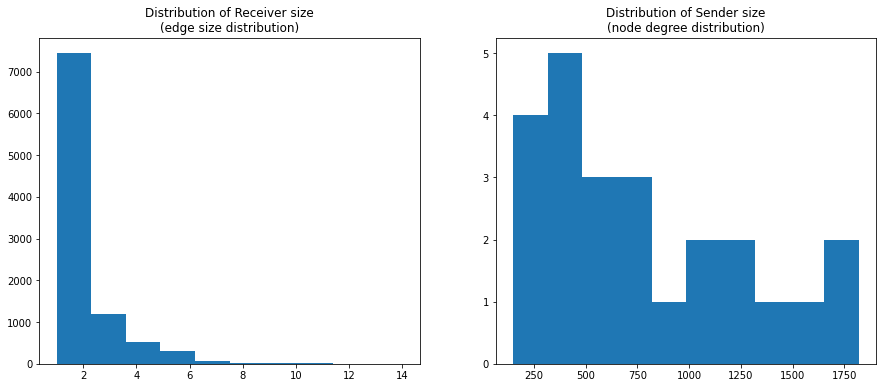

In [7]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
ax[0].hist(ed)
ax[0].set_title('Distribution of Receiver size\n(edge size distribution)')
ax[1].hist(nd)
ax[1].set_title('Distribution of Sender size\n(node degree distribution)');

### Collapse the edges which contain the same nodes.

In [8]:
%%time
Hc,equiv_classes = H.collapse_edges(return_equivalence_classes=True)

# CPU times: user 16.1 s, sys: 72.8 ms, total: 16.1 s
# Wall time: 16.1 s

CPU times: user 238 ms, sys: 3.75 ms, total: 241 ms
Wall time: 241 ms


In [9]:
## This reduced the number of edges by about 75%
H.shape,Hc.shape

((24, 9623), (24, 1875))

### Identify The Largest Edges in the Collapsed Hypergraph

In [10]:
%%time
### NWHy generates a NWHy hypergraph object
if Hc.nwhy:
    print('H.nwhy=True',H.g)
    ed = Hc.g.edge_size_dist()
    nd = Hc.g.node_size_dist()
else:
    print('H.nwhy=False')
    ed = Hc.edge_size_dist()
    nd = hnx.degree_dist(Hc)


H.nwhy=False
CPU times: user 5.16 ms, sys: 1.04 ms, total: 6.19 ms
Wall time: 5.2 ms


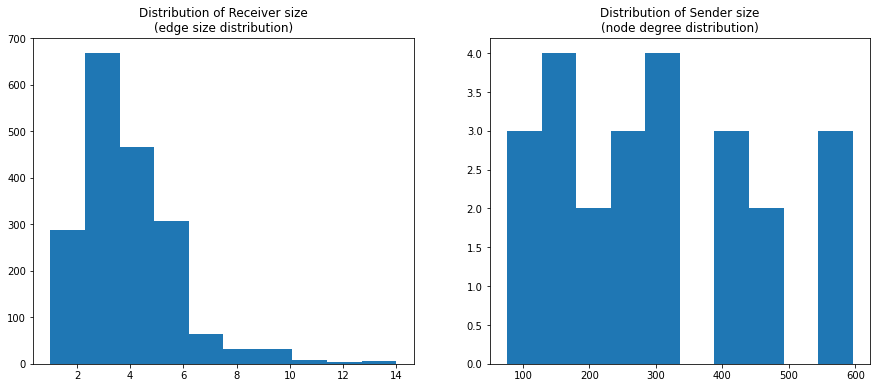

In [11]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
ax[0].hist(ed)
ax[0].set_title('Distribution of Receiver size\n(edge size distribution)')
ax[1].hist(nd)
ax[1].set_title('Distribution of Sender size\n(node degree distribution)');

### Good Receivers: Restrict to Receivers connected to more than a fixed number of senders and compute their metrics

In [12]:
## restrict to receivers who are connected to more than K senders: |r|>K
K=10
good_receivers = [r for r in Hc.edges if Hc.size(r)>K]
len(good_receivers)

18

In [13]:
Hgr = Hc.restrict_to_edges(good_receivers)

In [14]:
Hgr.shape

(24, 18)

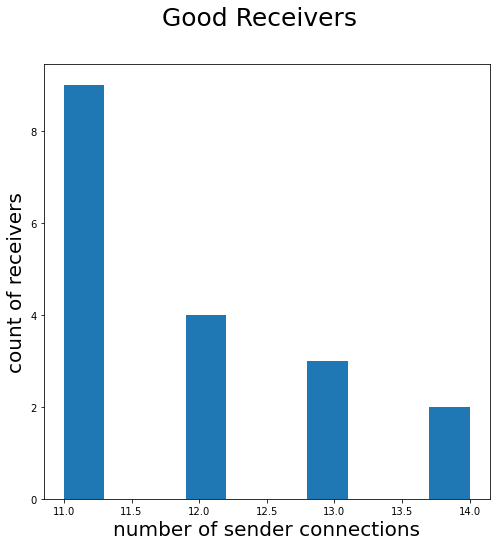

In [15]:
## Size Distribution
fig,ax = plt.subplots()
fig.suptitle('Good Receivers',fontsize=25)
ax.hist(hnx.dist_stats(Hgr)['edge size list'])
ax.set_xlabel('number of sender connections',fontsize=20)
ax.set_ylabel('count of receivers',fontsize=20);

# S-Metrics

## Line Graphs 
HNX uses s-linegraphs to compute graph-like statistics on hypergraphs. We use NetworkX (Python) and NWHypergraph (C++) to compute the statistics. The library chosen depends on the size of the hypergraph and whether or not NWHy is available.

**Node Line Graphs** -> H-nodes become Nodes in the Graph 
- s-connected if they commonly belong to s H-edges

**Edge Line Graphs** -> H-edges become Nodes in the Graph 
- s-connected if they intersect in s H-nodes 

<img src='images/s-width.png' width='500px' style="float:left;margin-right:30pt"></img>


## S-Linegraph

By default the `s_component_subgraphs` method defines s-connectivity using the edge s-linegraph. To define connectivity in terms of the node linegraph set edges=False in the signature. Here we will compute the s-connected component subgraphs and the centrality of the edges in the non-trivial components. 

Singleton components are only returned if return_singletons=True.


In [16]:
%%time
comps = {s: list(Hgr.s_component_subgraphs(s=s, edges=True, return_singletons=False)) for s in range(1,25)}

# CPU times: user 7.37 s, sys: 83.2 ms, total: 7.45 s
# Wall time: 7.3 s

CPU times: user 1.3 s, sys: 10.6 ms, total: 1.31 s
Wall time: 1.31 s


### Nontrivial s-connected components for each value of s

In [17]:
compdf = pd.DataFrame(columns=['s','#-non-trivial','shape(s)'])
for s,v in comps.items():
    if len(v) !=0:
        compdf = compdf.append([dict(zip(['s','#-non-trivial','shape(s)'],
                                [s,len(comps[s]),[cdx.shape for cdx in comps[s]]]))],ignore_index=True)
    else:
        compdf = compdf.append([dict(zip(['s','#-non-trivial','shape(s)'],
                                [s,0,(0,0)]))],ignore_index=True)
compdf

,s,#-non-trivial,shape(s)
0,1,1,"[(24, 18)]"
1,2,1,"[(24, 18)]"
2,3,1,"[(24, 18)]"
3,4,1,"[(24, 18)]"
4,5,1,"[(24, 18)]"
5,6,1,"[(24, 18)]"
6,7,1,"[(24, 18)]"
7,8,1,"[(24, 18)]"
8,9,1,"[(24, 15)]"
9,10,1,"[(23, 8)]"


In [18]:
max_nontrivial = np.argmax(compdf['#-non-trivial'])

## Centrality Statistics:

We compute the s-centrality edge statistics for $1 \leq s < 20$. We then examine plots to compare the values across the edges.

### s-closeness centrality
If $u$ is a vertex in one of the s-line graphs above, the s-closeness centrality is computed on each of the connected components

$V$ = the set of vertices in the linegraph.  
$n = |V|$
$$C(u) = \frac{n - 1}{\sum_{v \neq u \in V} d(v, u)}$$

In [19]:
%%time
scc = dict()
for s in range(1,max_nontrivial):
    scc[s] = hnx.s_closeness_centrality(comps[s][0],s=s,edges=True,use_nwhy=True)
    
# CPU times: user 7.41 s, sys: 122 ms, total: 7.53 s
# Wall time: 7.18 s

CPU times: user 1.2 s, sys: 4.41 ms, total: 1.2 s
Wall time: 1.2 s


### s-betweenness centrality
The centrality of edge to all shortest s-edge paths
$V$ = the set of vertices in the linegraph.  
$\sigma(s,t)$ = the number of shortest paths between vertices $s$ and $t$.  
$\sigma(s, t|v)$ = the number of those paths that pass through vertex $u$
$$c_B(u) =\sum_{s \neq t \in V} \frac{\sigma(s, t|u)}{\sigma(s, t)}$$

In [20]:
%%time
sbc = dict()
for s in range(1,max_nontrivial):
    sbc[s] = hnx.s_betweenness_centrality(comps[s][0],s=s,edges=True,use_nwhy=True)
    
# CPU times: user 7.43 s, sys: 48.1 ms, total: 7.48 s
# Wall time: 7.37 s

CPU times: user 1.23 s, sys: 12.6 ms, total: 1.25 s
Wall time: 1.24 s


### s-harmonic centrality - 

The denormalized reciprocal of the harmonic mean of all distances from $u$ to all other vertices.  
$V$ = the set of vertices in the linegraph.
$$C(u) = \sum_{v \neq u \in V} \frac{1}{d(v, u)}$$

Normalized this becomes:
$$C(u) = \sum_{v \neq u \in V} \frac{1}{d(v, u)}\cdot\frac{2}{(n-1)(n-2)}$$
where $n$ is the number vertices.

In [21]:
%%time
shc = dict()
for s in range(1,max_nontrivial):
    shc[s] = hnx.s_harmonic_centrality(comps[s][0],s=s,edges=True,use_nwhy=True)
    
# CPU times: user 7.53 s, sys: 98.5 ms, total: 7.63 s
# Wall time: 7.35 s

CPU times: user 1.17 s, sys: 4.93 ms, total: 1.18 s
Wall time: 1.18 s


In [22]:
%%time
shcn = dict()
for s in range(1,max_nontrivial):
    shcn[s] = hnx.s_harmonic_centrality(comps[s][0],s=s,edges=True,use_nwhy=True,normalized=True)
    
# CPU times: user 7.68 s, sys: 50.1 ms, total: 7.73 s
# Wall time: 7.53 s

CPU times: user 1.18 s, sys: 6.81 ms, total: 1.18 s
Wall time: 1.18 s


### s-eccentricity -
The length of the longest shortest path from a vertex $u$ to every other vertex in the linegraph.  
$V$ = set of vertices in the linegraph
$$ \text{s-ecc}(u) = \text{max}\{d(u,v): v \in V\} $$

In [23]:
%%time
sec = dict()
for s in range(1,max_nontrivial):
    sec[s] = hnx.s_eccentricity(comps[s][0],s=s,edges=True,use_nwhy=True)
    
# CPU times: user 7.66 s, sys: 50.7 ms, total: 7.71 s
# Wall time: 7.49 s

CPU times: user 1.18 s, sys: 7.06 ms, total: 1.19 s
Wall time: 1.19 s


## Plot the centrality metrics

In [24]:
scex = [scc,sbc,shc,shcn,sec]
scnames = ['s-Closeness Centrality','s-Betweenness Centrality',
           's-Harmonic Centrality','s-Harmonic Centrality normalized','s-Eccentricity']

In [25]:
## specify which centrality to view from scnames by index
i = 0 ## index of centrality score type
ex = scex[i]  ## dictionary of centrality scores keyed by s

In [26]:
## Collect points to plot
S = sorted(ex.keys()) ## all s values we are evaluating
indexdict = defaultdict(list) ## nd position in each s by centrality score
valdict = dict() ## s:{score:[nds]} groups nodes by their scores
vals = dict()
for s in S:
    d = defaultdict(list) ## temporary score:[nds] dictionary
    for nd,val in ex[s].items():
        d[val].append(nd)
    vals[s] = sorted(list(d.keys()),reverse=True) ## sort keys of scores large to small
    for vdx,val in enumerate(vals[s]):
        for nd in d[val]:
                indexdict[nd].append(vdx)  ## nd: position indexed by s
    valdict[s] = OrderedDict([(vdx,d[val]) for vdx,val in enumerate(vals[s])]) ## organize scores by value

yindex = defaultdict(list)
for sdx,s in enumerate(S):    
    for k,nds in valdict[s].items():
        ## sorts elements with the same score by successive scores - lexi-like
        yindex[s] += sorted(list(nds),key = lambda nd : sum(indexdict[nd][sdx:])) 
        
specpos = defaultdict(list) ## plots by relative position in ordering
specvals = defaultdict(list) ## plots by value

## generate points
for s in S:
    topval = Hgr.shape[1]
    for ndx,nd in enumerate(yindex[s]):
        specpos[nd].append(topval-ndx)
        specvals[nd].append([s,vals[s][indexdict[nd][s-1]]])
        
## set up for plotting
for nd in specpos:
    specpos[nd] = np.array(specpos[nd]) ## an array for plotting sequential positions
    specvals[nd] = np.array(specvals[nd]).T  ## x,y arrays
    


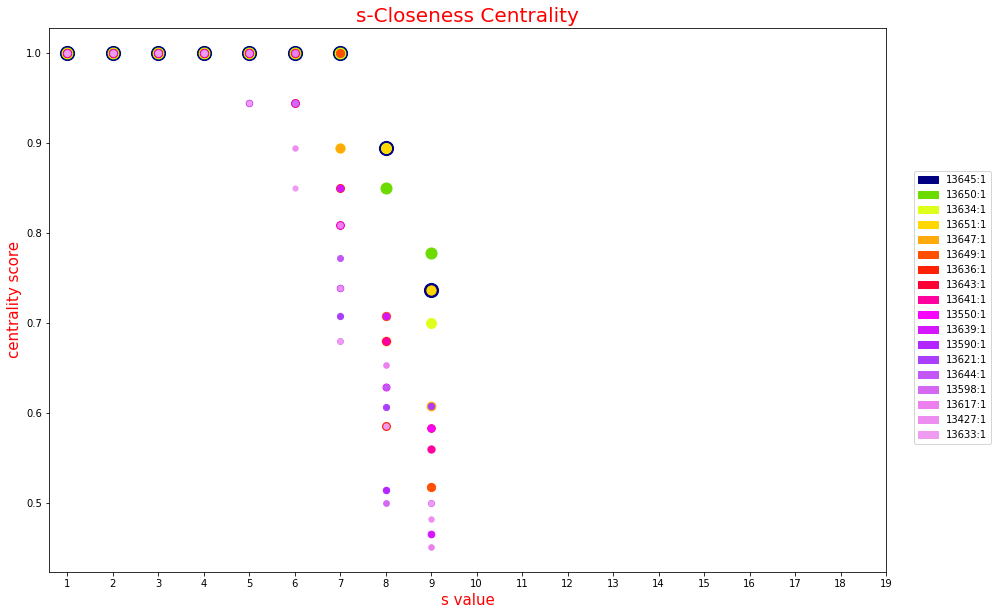

In [27]:
## Plot by value

s = 1  ## limit to nodes in s-linegraph
N = len(yindex[s])
_cmap = cm.gist_ncar

K1 = 20  ## constant spreads out colors so that they don't bunch up at the beginning
colors = [idx/100 for idx in K1*np.log(np.linspace(1,100,N))]  
cmap = lambda idx : _cmap(colors[idx])

K2 = 35  ## constant reduces size tapering off at the end
stops = K2*np.log(np.linspace(1,150,N+1)) ## reduce size to prevent occlusion

nodes = list(yindex[s]) ## plot values only for nodes still around for this value of s

fig,ax = plt.subplots(figsize=(15,10))

patch = dict()
for idx,nd in enumerate(nodes):
    ax.scatter(specvals[nd][0], specvals[nd][1], s=200-stops[idx], color=cmap(idx))
    patch[nd] = mpatches.Patch(color=cmap(idx), label=nd)
#     ax.scatter(specvals[nd][0],specvals[nd][1], s=200-15*idx, color=cmap(colors[idx]))

ax.set_title(scnames[i],fontsize=20,color='r')
ax.set_xticks(range(1,20))
# ax.set_yticks(np.linspace(0,1,11))
ax.set_xlabel('s value',fontsize=15,color='r')
ax.set_ylabel('centrality score',fontsize=15,color='r')


fig.legend(handles=[patch[nd] for nd in nodes],loc="right");

### Positional Plot - receivers ordered by centrality value

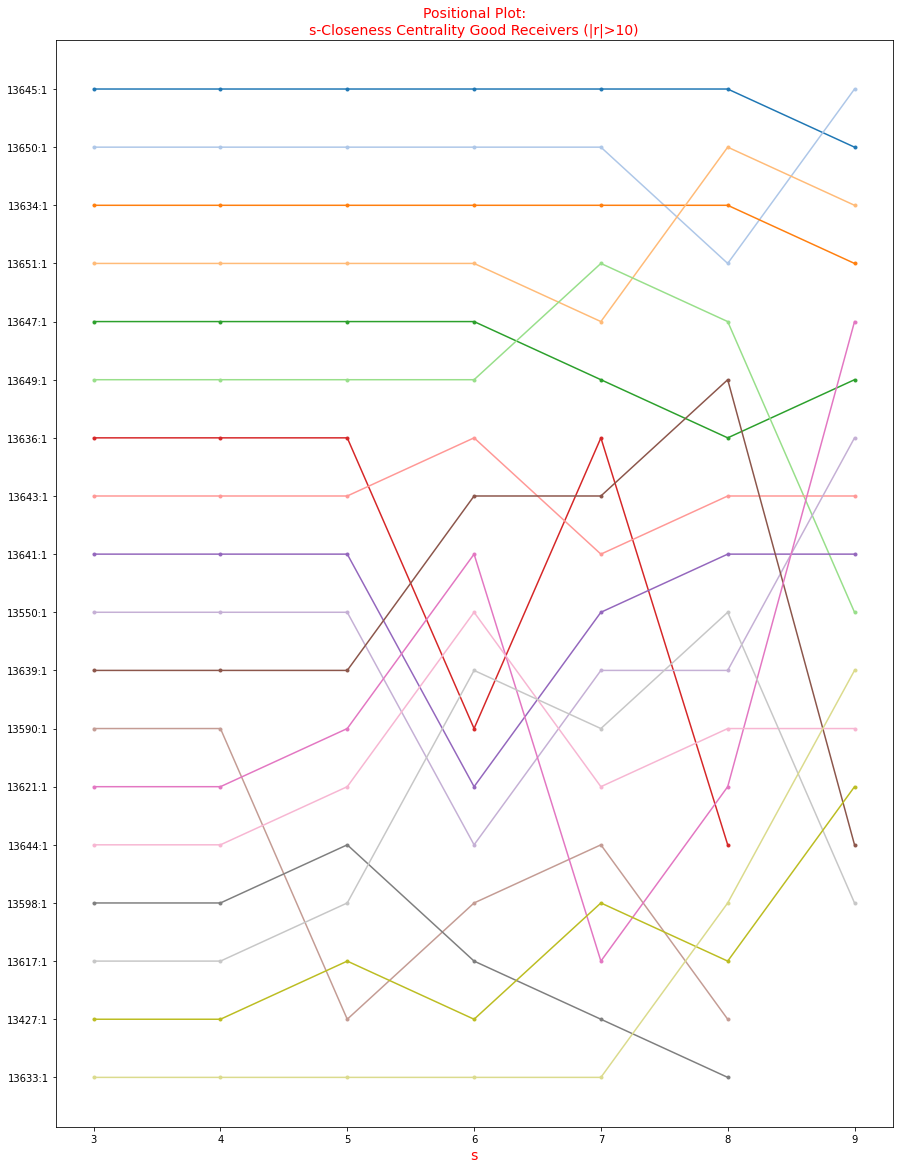

In [28]:
## Positional plot starting at specified s value
_cmap = cm.tab20
cmap = lambda idx : _cmap(idx%20)

starts = 3  ## Limits first xtick to show in plot
starts -=1
fig,ax = plt.subplots(1,1,figsize=(15,20))
ax.set_yticks([v[0] for v in specpos.values()])
ax.set_yticklabels([k for k in specpos])
ax.set_xticks(range(20-starts))
ax.set_xticklabels([str(x+1) for x in range(starts,20)])

ax.set_xlabel('s',fontsize=14,color='r')

for idx,nd in enumerate(specpos):
    if len(specpos[nd]) == 0:
        continue
    ax.plot(specpos[nd][starts:],marker='.', color = cmap(idx))

plt.title(f'Positional Plot:\n{scnames[i]} Good Receivers (|r|>{K})',fontsize=14,color='r');

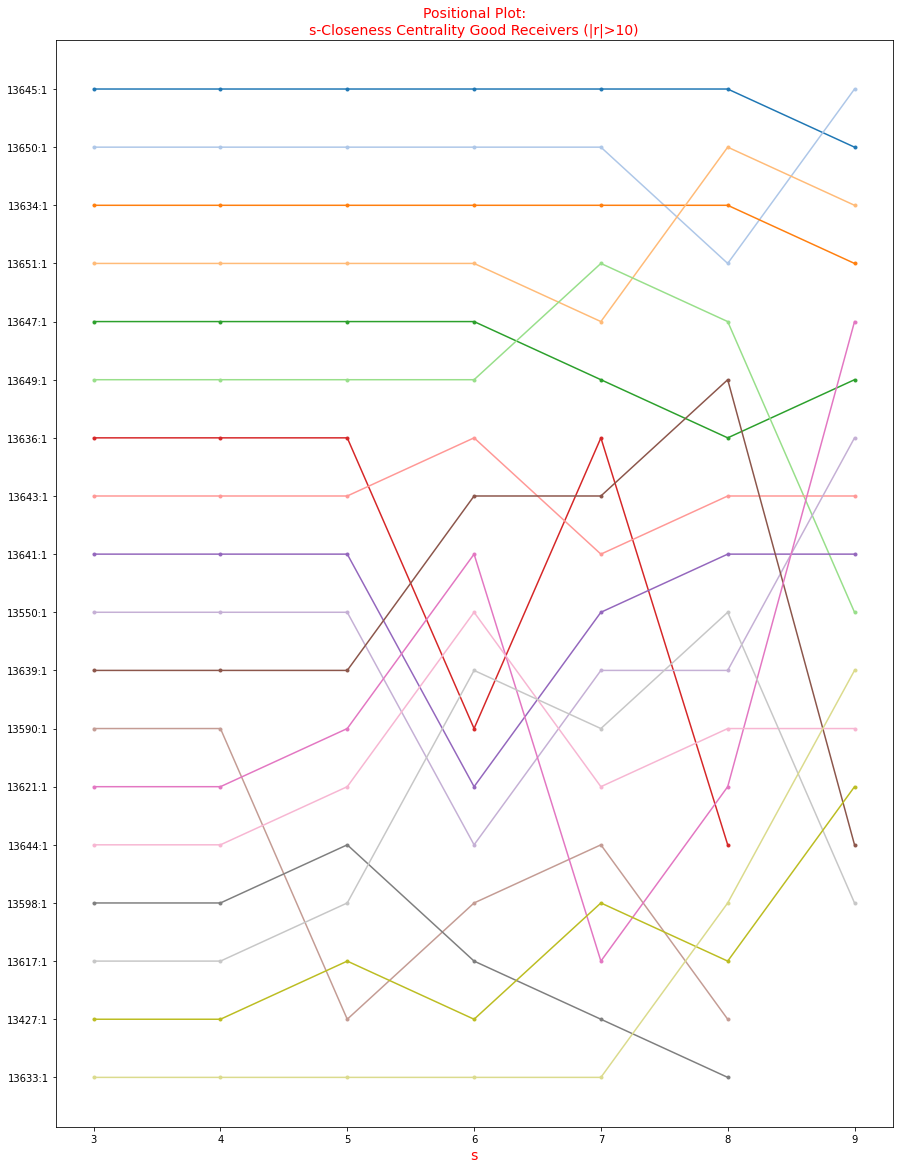

In [29]:
## Positional plot starting at specified s value
fig,ax = plt.subplots(1,1,figsize=(15,20))
_cmap = cm.tab20
cmap = lambda idx : _cmap(idx%20)

starts = 3  ## Limits first xtick to show in plot
starts -=1
ax.set_yticks([v[0] for v in specpos.values()])
ax.set_yticklabels([k for k in specpos])
ax.set_xticks(range(20-starts))
ax.set_xticklabels([str(x+1) for x in range(starts,20)])

ax.set_xlabel('s',fontsize=14,color='r')

for idx,nd in enumerate(specpos):
    if len(specpos[nd]) == 0:
        continue
    ax.plot(specpos[nd][starts:],marker='.', color = cmap(idx))

plt.title(f'Positional Plot:\n{scnames[i]} Good Receivers (|r|>{K})',fontsize=14,color='r');